In [1]:
%matplotlib inline

import time

import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt


In [2]:
BLACK = [0, 0, 0]
WHITE = [255, 255, 255]
BLUE = [0, 0, 255]
GREEN = [0, 255, 0]
YELLOW = [255, 255, 0]

FREE_CELL = 0
OBSTACLE = 1
START = 2
GOAL = 3

In [3]:
antenna_reward = 0.7
base_reward = 0.2

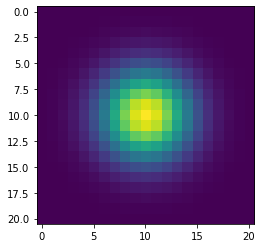

In [4]:
radius = 10
sigma = 3
mu = 0
from scipy.stats import multivariate_normal

gauss2d = multivariate_normal([mu, mu], [[sigma ** 2, 0], [0, sigma ** 2]])
X, Y = np.meshgrid(np.arange(-radius, radius + 1), np.arange(-radius, radius + 1))
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
antenna_distribution = gauss2d.pdf(pos)
antenna_distribution -= antenna_distribution.min()
antenna_distribution *= antenna_reward / antenna_distribution.max()
plt.imshow(antenna_distribution)

In [5]:
class SUMProductSpeed:
    def __init__(self, apm, mappa, reward=None):
        self.apm = np.copy(apm)
        self.mappa = np.copy(mappa)
        self.d = self.apm.shape[-1] // 2
        self.apm_mask = np.any(self.apm, 0)
        self.conv_apm = np.transpose(np.expand_dims(self.apm, -1), (1, 2, 3, 0))
        self.reward = np.copy(reward) * self.mappa if reward is not None else np.tile(self.mappa[np.newaxis, :],
                                                                                      (self.apm.shape[0], 1, 1))
        self.prob_mask = tf.nn.conv2d(self.mappa[np.newaxis, :, :, np.newaxis], self.conv_apm, 1, 'SAME')
        self.prob_mask = tf.squeeze(tf.transpose(self.prob_mask, (3, 1, 2, 0))).numpy()
        for i, j, k in np.argwhere(self.prob_mask == 0):
            self.reward[i, j, k] = 0
            self.prob_mask[i, j, k] = 1

    def run_min_path(self, start, goals, T_max=1000):
        t = 1
        c = (self.apm.shape[-1] ** 2) // 2
        b_as = np.zeros(self.apm.shape[:1] + self.mappa.shape)
        b_as[c, goals == 1] = 1.
        actions = np.zeros(self.apm.shape[:1] + self.mappa.shape, np.int32)
        actions[c, goals == 1] = 1
        b = np.sum(b_as, 0)
        while not np.sum(actions * start) and t < T_max:
            nb = self._nozero_cross_correlation(np.any(b_as, 0), b)
            nb *= self.reward / self.prob_mask
            # b = np.sum(nb, 0)
            # nb[:, b != 0] /= b[np.newaxis, b != 0]
            b = np.sum(nb, 0)
            b_as_pad = np.pad(b_as, [[0, 0], [self.d, self.d], [self.d, self.d]])
            for i, j in np.argwhere(b):
                actions[np.argmax(
                        np.sum(b_as_pad[:, i:i + self.apm.shape[1], j:j + self.apm.shape[2]] * self.apm, 0)), i, j] = 1
            b_as += nb
            t += 1
        path = np.zeros(self.mappa.shape) if not np.sum(actions * start) else self._generate_path(start, goals, actions)
        return t, path

    def _nozero_cross_correlation(self, T, M):
        temp = np.zeros(np.add(2 * self.d, M.shape))
        nb = np.zeros(self.apm.shape[:1] + M.shape)
        M_pad = np.pad(M, self.d)
        for i, j in np.argwhere(M):
            temp[i:i + self.apm.shape[1], j:j + self.apm.shape[2]] = self.apm_mask
        temp = temp[self.d:-self.d, self.d:-self.d]
        temp[(T + M) != 0] = 0
        for i, j in np.argwhere(temp):
            nb[:, i, j] = np.sum(
                    self.apm * M_pad[i:i + self.apm.shape[1], j:j + self.apm.shape[2]], axis=(1, 2))
        return nb

    def run_path(self, start, goals, T_max=1000000):
        t = 1
        c = (self.apm.shape[-1] ** 2) // 2
        b_as = np.zeros(self.apm.shape[:1] + self.mappa.shape)
        b_as[c, goals == 1] = 1.
        nb = np.copy(b_as)
        actions = np.zeros(self.apm.shape[:1] + self.mappa.shape, np.int32)
        actions[c, goals == 1] = 1
        b = np.sum(b_as, 0)
        while np.any(nb) and t < T_max:
            nb = self._nozero_cross_correlation2(b_as, b)
            nb *= self.reward / self.prob_mask
            b = np.sum(nb, 0)
            b_as_pad = np.pad(b_as, [[0, 0], [self.d, self.d], [self.d, self.d]])
            for i, j in np.argwhere(b):
                zeros = np.zeros(self.apm.shape[0])
                zeros[np.argmax(
                        np.sum(b_as_pad[:, i:i + self.apm.shape[1], j:j + self.apm.shape[2]] * self.apm, 0))] = 1
                actions[:, i, j] = zeros
                b_as[:, i, j] = nb[:, i, j]
            b_as[:, start == 1] = 0
            b[start == 1] = 0
            t += 1
        path = np.zeros(self.mappa.shape) if not np.sum(actions * start) else self._generate_path(start, goals, actions)
        return t, path

    def _nozero_cross_correlation2(self, T, M):
        temp = np.zeros(np.add(2 * self.d, M.shape))
        nb = np.zeros(self.apm.shape[:1] + M.shape)
        M_pad = np.pad(M, self.d)
        for i, j in np.argwhere(M):
            temp[i:i + self.apm.shape[1], j:j + self.apm.shape[2]] = self.apm_mask
        temp = temp[self.d:-self.d, self.d:-self.d]
        for i, j in np.argwhere(temp):
            new_value = np.sum(
                    self.apm * M_pad[i:i + self.apm.shape[1], j:j + self.apm.shape[2]], axis=(1, 2))
            nb[:, i, j] = new_value if np.max(new_value) > np.max(T[:, i, j]) else T[:, i, j]
        return nb

    def _generate_path(self, start, goals, actions):
        path = np.zeros(self.mappa.shape)
        path[start == 1] = 1
        i, j = np.argwhere(path)[0]
        while not path[goals == 1]:
            shap = (self.apm.shape[1], -1)
            ac = actions[:, i, j]
            res = np.reshape(ac, shap)
            arg = np.argwhere(res)[0]
            i, j = np.add([i - self.d, j - self.d],
                          arg)
            path[i, j] = 1
        return path

In [6]:
def gen_apm():
    A = 1 / 18 * np.ones(8)
    A[[0, 2]] = 1 / 6
    A[1] = 1 / 3
    apm = 1 / 18 * np.ones((9, 9))
    apm[4] = 1 / 16 * np.ones(9)
    apm[4, 4] = 1 / 2
    for i in [0, 1, 2, 5, 8, 7, 6, 3]:
        apm[i, [3, 5]] = A[[0, 4]]
        apm[i, :3] = A[1:4]
        apm[i, 6:] = A[5:8][::-1]
        A = np.roll(A, 1)
    return np.reshape(apm, (9, 3, 3))

In [7]:
def test(model, apm, mappa, start, goals, reward=None, tmax=1000, plot_title='Path'):
    timer = time.time()
    sp = model(apm, mappa, reward)
    t, p = sp.run_min_path(start, goals, tmax) if reward is None else sp.run_path(start, goals, tmax)
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].axis('off')
    ax[0].set_title('Map')
    ax[0].imshow(mappa)
    ax[1].set_title(plot_title)
    ax[1].axis('off')
    ax[1].imshow(p)
    print("Time elapsed = {:.3f} seconds, to perform {:d} steps on a map {:d} × {:d}".format(time.time() - timer, t,
                                                                                             mappa.shape[0],
                                                                                             mappa.shape[1]))
    return t, p

In [8]:
def best_path(image_path, with_rewards=True):
    image = Image.open(image_path)
    size = image.size
    data = np.asarray(image)
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.axis('off')
    ax.set_title('Map')
    ax.imshow(data)
    cell_types = np.zeros(size, dtype=int)
    c = np.zeros(size, dtype=np.float32)
    antenna_indexes = []
    for x in range(size[0]):
        for y in range(size[1]):
            cell = data[x, y, :]
            if np.array_equal(cell, BLACK):
                cell_types[x, y] = OBSTACLE
                c[x, y] = 0
            elif np.array_equal(cell, WHITE):
                cell_types[x, y] = FREE_CELL
                c[x, y] = base_reward
            elif np.array_equal(cell, GREEN):
                cell_types[x, y] = START
                c[x, y] = 1.0
            elif np.array_equal(cell, BLUE):
                cell_types[x, y] = GOAL
                c[x, y] = 1.0
            elif np.array_equal(cell, YELLOW):
                cell_types[x, y] = OBSTACLE
                antenna_indexes.append((x, y))
    obstacle_map = np.where(cell_types == OBSTACLE, 0, 1).astype(np.float32)

    start = np.copy(cell_types)
    start = np.where(start != START, 0, start)
    start = np.where(start == START, 1, start).astype(np.float32)

    goal = np.copy(cell_types)
    goal = np.where(goal != GOAL, 0, goal)
    goal = np.where(goal == GOAL, 1, goal).astype(np.float32)

    if len(antenna_indexes) > 0 and with_rewards:
        for index in antenna_indexes:
            x = index[0]
            y = index[1]
            x_min_radius = x if x <= radius else radius
            x_max_radius = radius + 1 if x + radius + 1 < size[0] else size[0] - x
            y_min_radius = y if y <= radius else radius
            y_max_radius = radius + 1 if y + radius + 1 < size[1] else size[1] - y
            distribution = antenna_distribution[radius - x_min_radius:radius + x_max_radius,
                           radius - y_min_radius:radius + y_max_radius]
            mask = obstacle_map[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius]
            c[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius] += mask * distribution
        c /= c.max()
        c[c > 0.9] = 0.9
        c[start == 1] = 1
        c[goal == 1] = 1
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.axis('off')
        ax.set_title('Map with antenna rewards')
        ax.imshow(c)

    _, p = test(SUMProductSpeed, gen_apm(), obstacle_map, start, goal,
                np.tile(c, (9, 1, 1)) if with_rewards else None,
                plot_title="Path with antennas" if with_rewards else "Path")

    return obstacle_map, p

KeyboardInterrupt: 

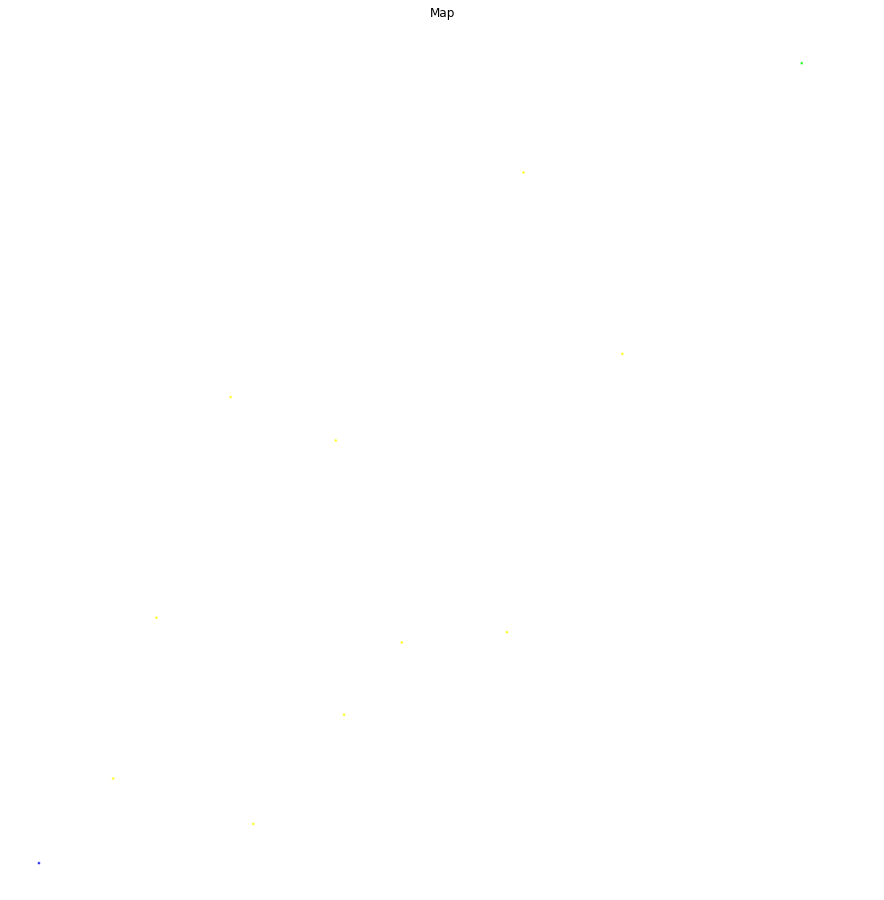

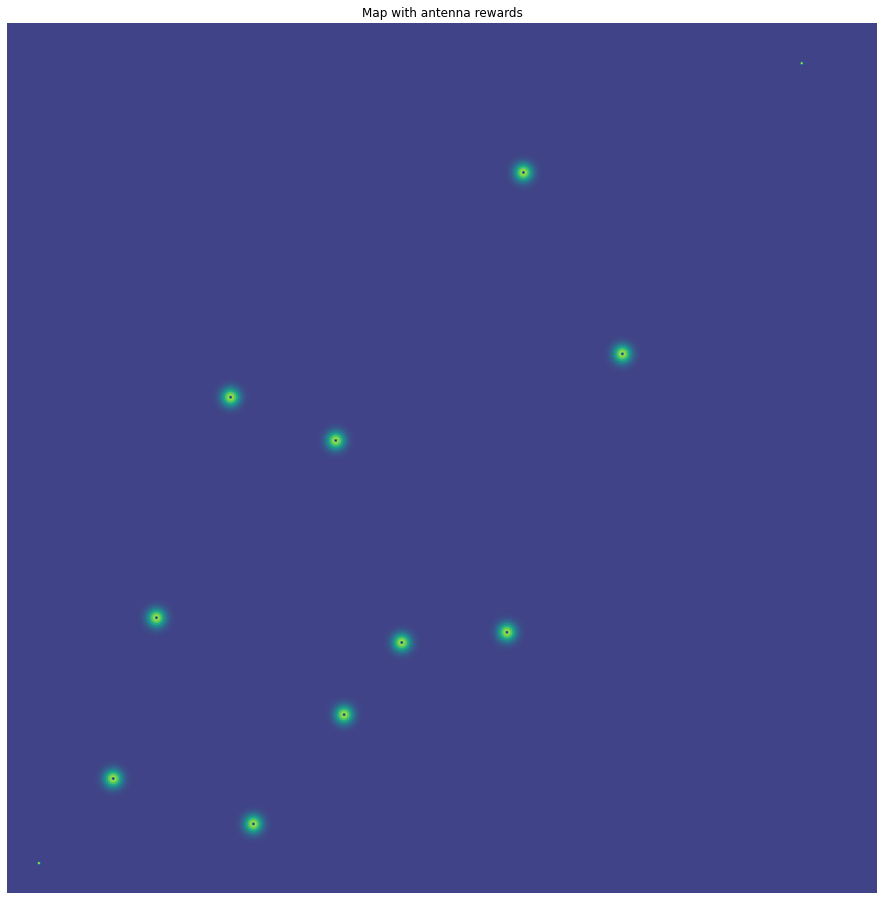

In [11]:
mappa, p = best_path("urban grids/empty.png")
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map with path')
ax.imshow(mappa + p);

KeyboardInterrupt: 

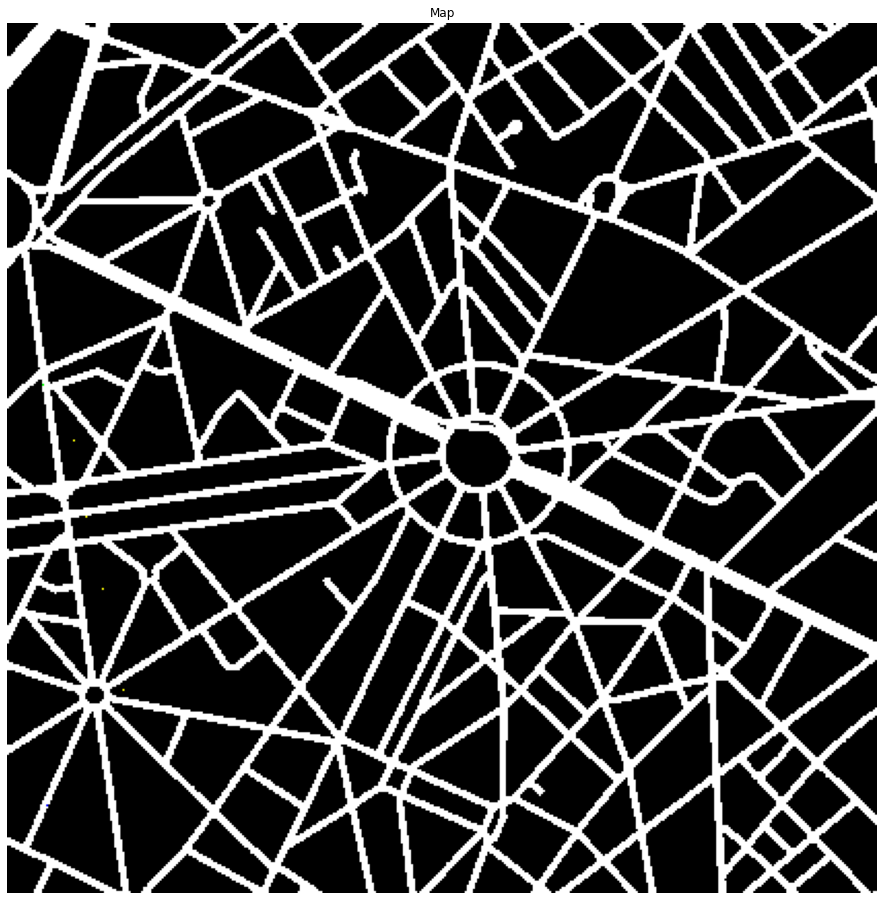

Error in callback <function flush_figures at 0x000001C00D7C2E50> (for post_execute):


KeyboardInterrupt: 

In [12]:
mappa, p = best_path("urban grids/paris.png")
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map with path')
ax.imshow(mappa + p);

Time elapsed = 7.782 seconds, to perform 133 steps on a map 422 × 422


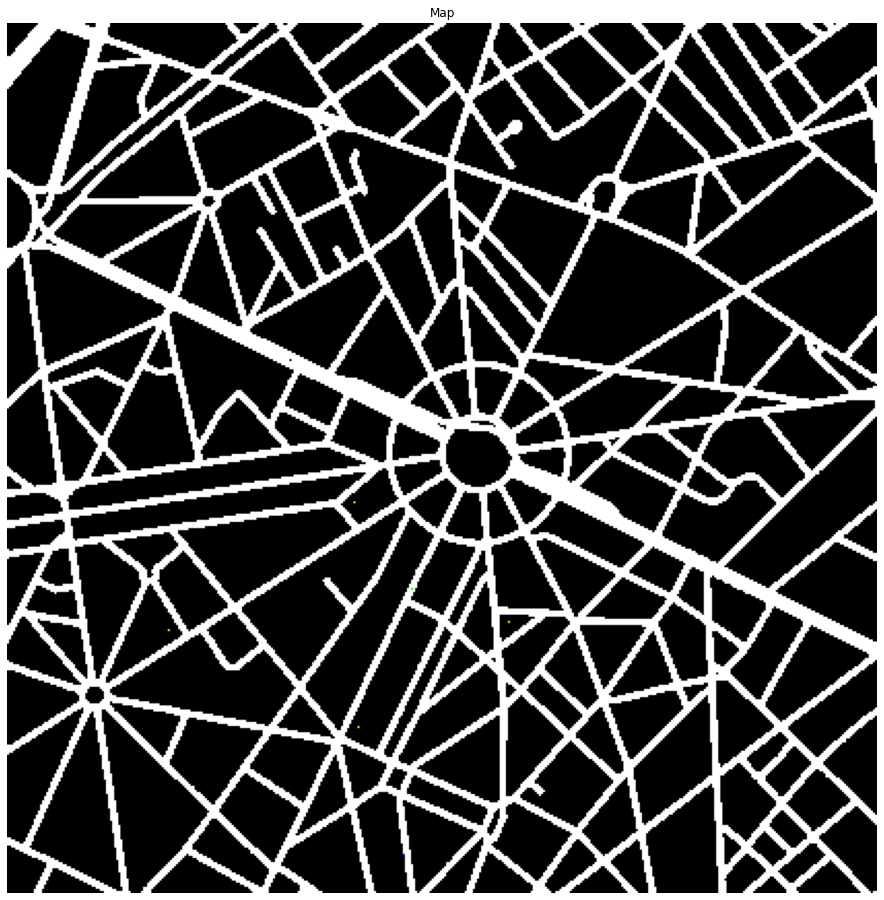

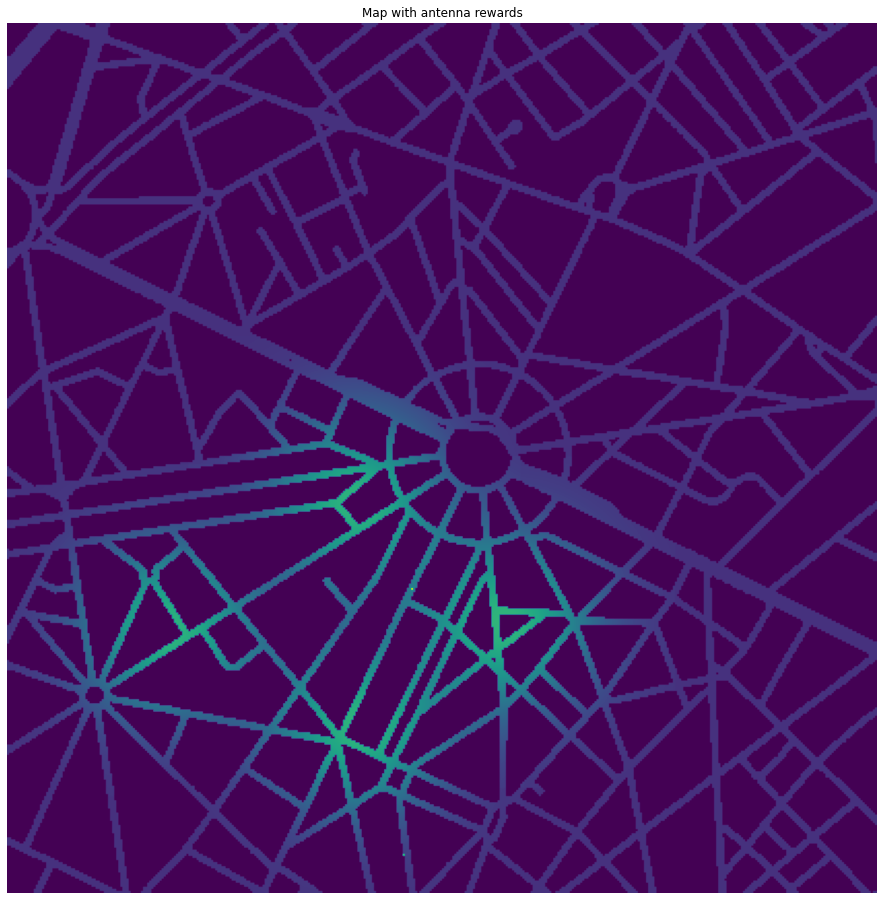

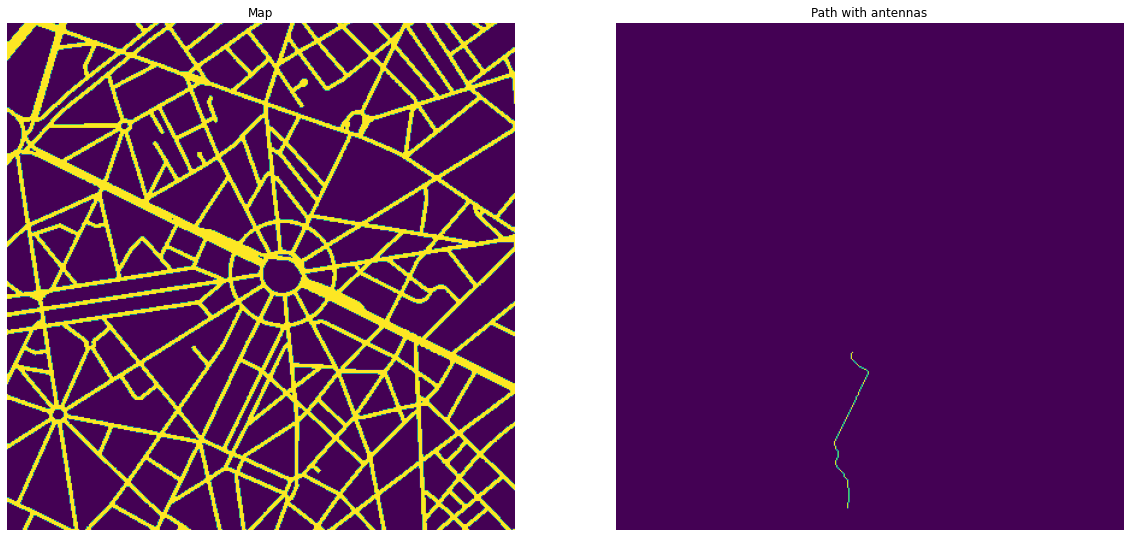

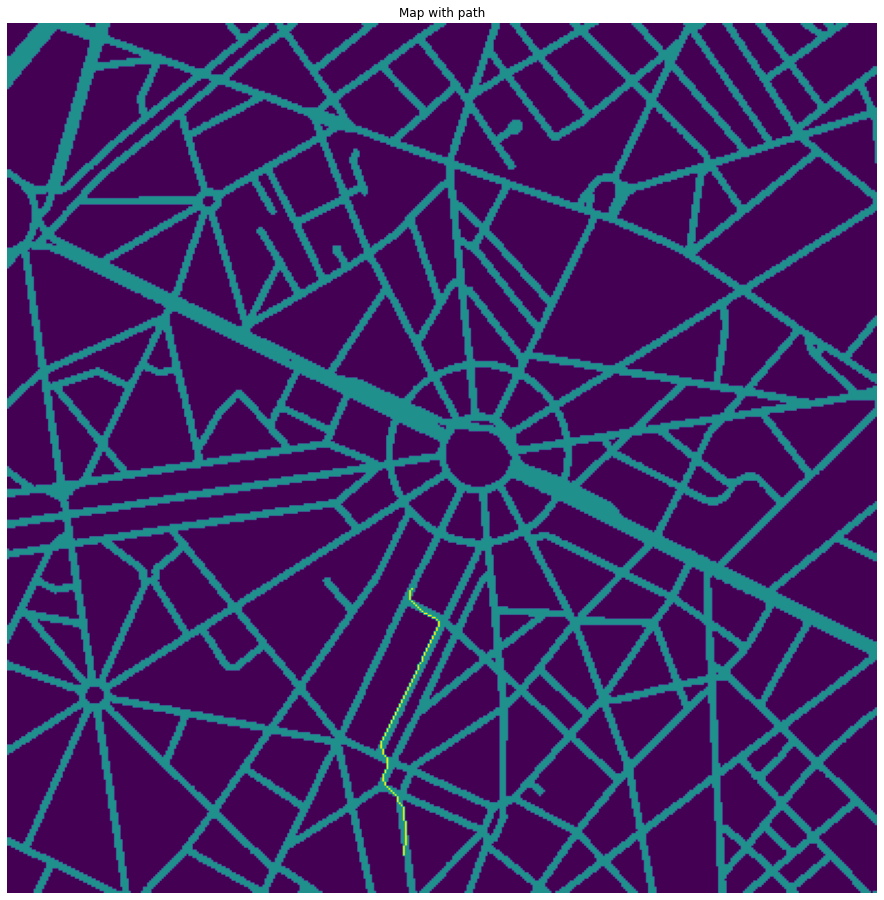

In [11]:
mappa, p = best_path("urban grids/paris2.png")
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map with path')
ax.imshow(mappa + p);

KeyboardInterrupt: 

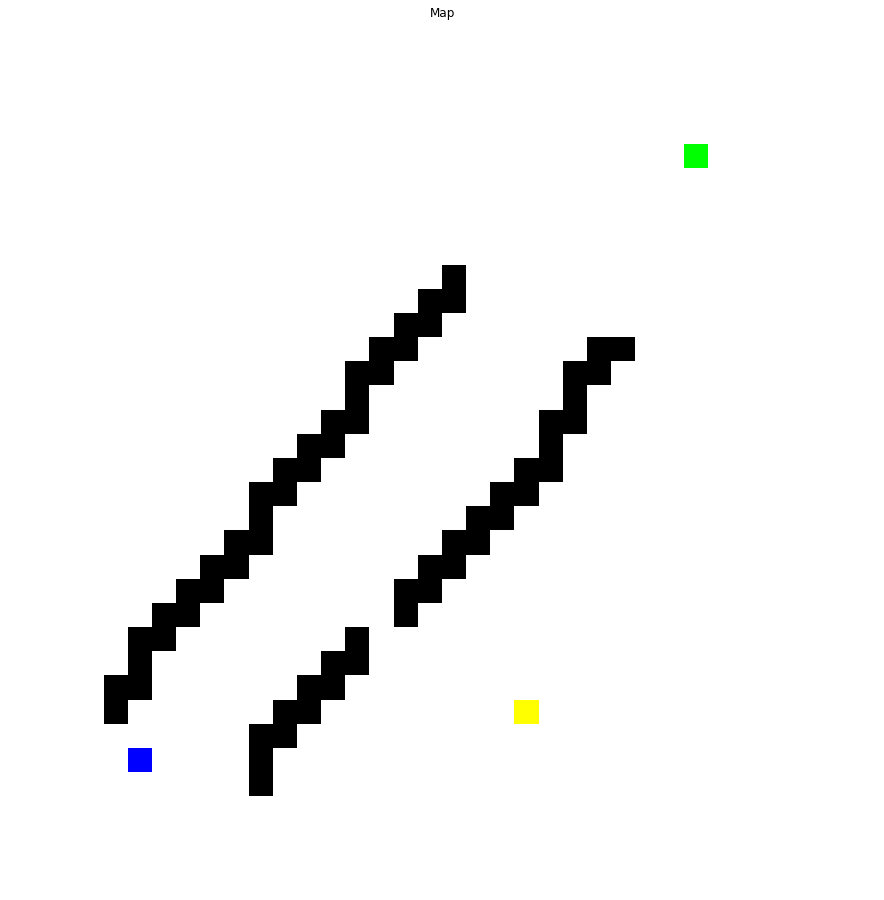

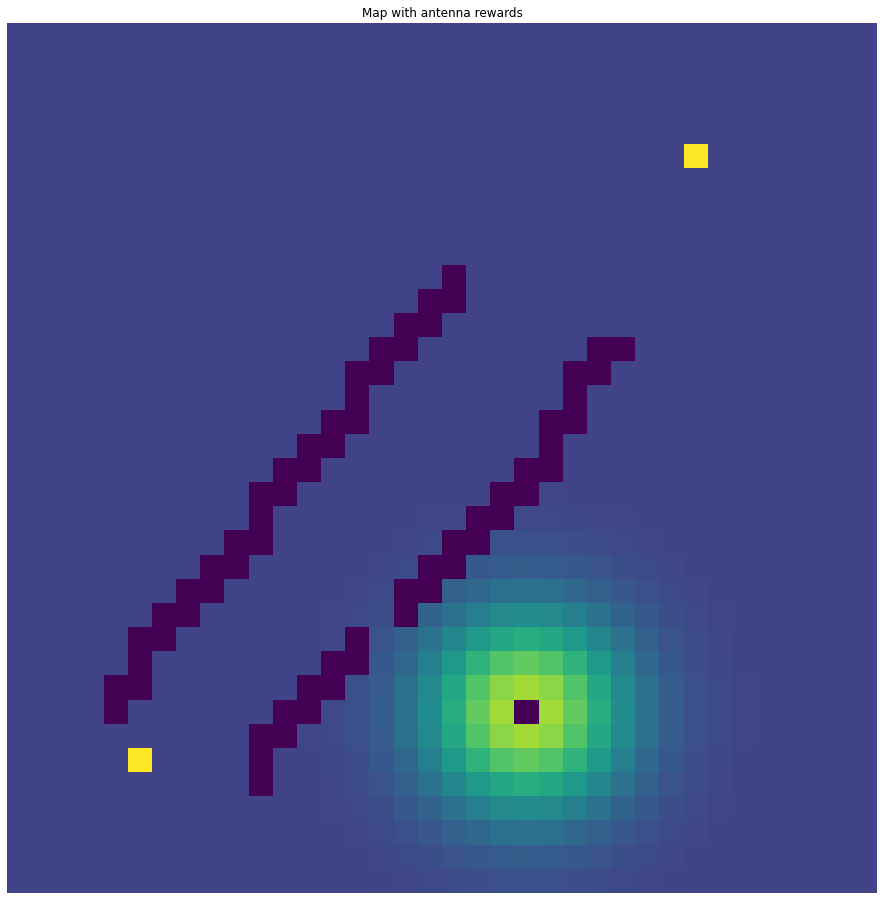

In [9]:
mappa, p = best_path("urban grids/small.png")
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map with path')
ax.imshow(mappa + p);

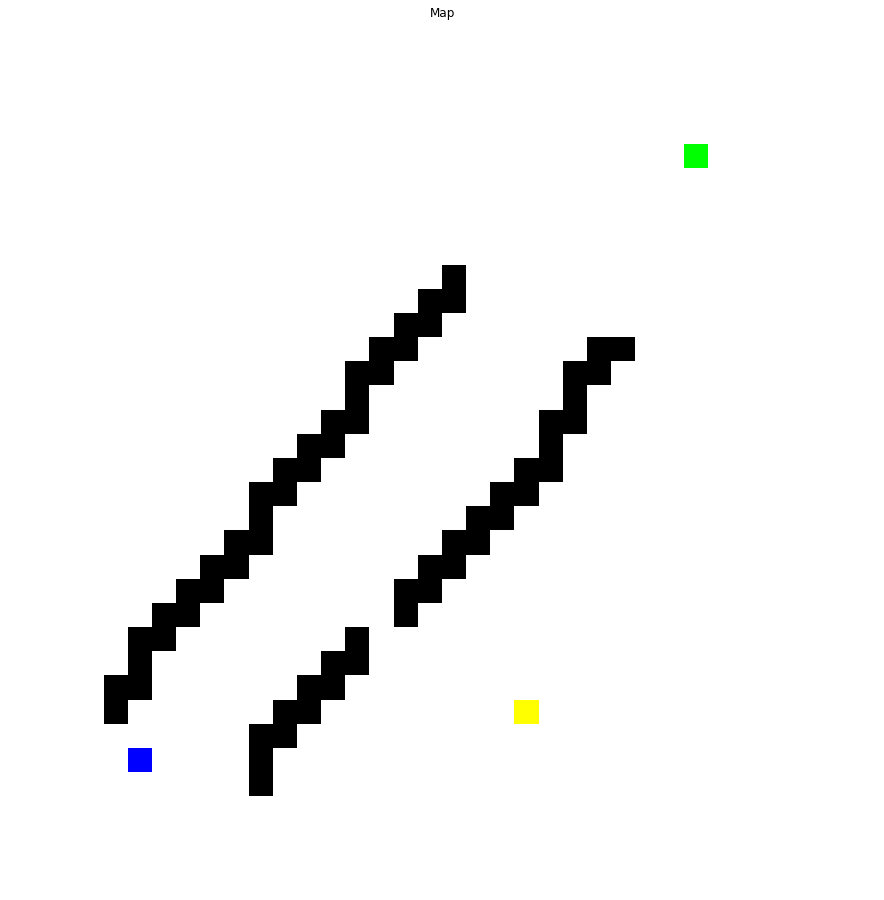

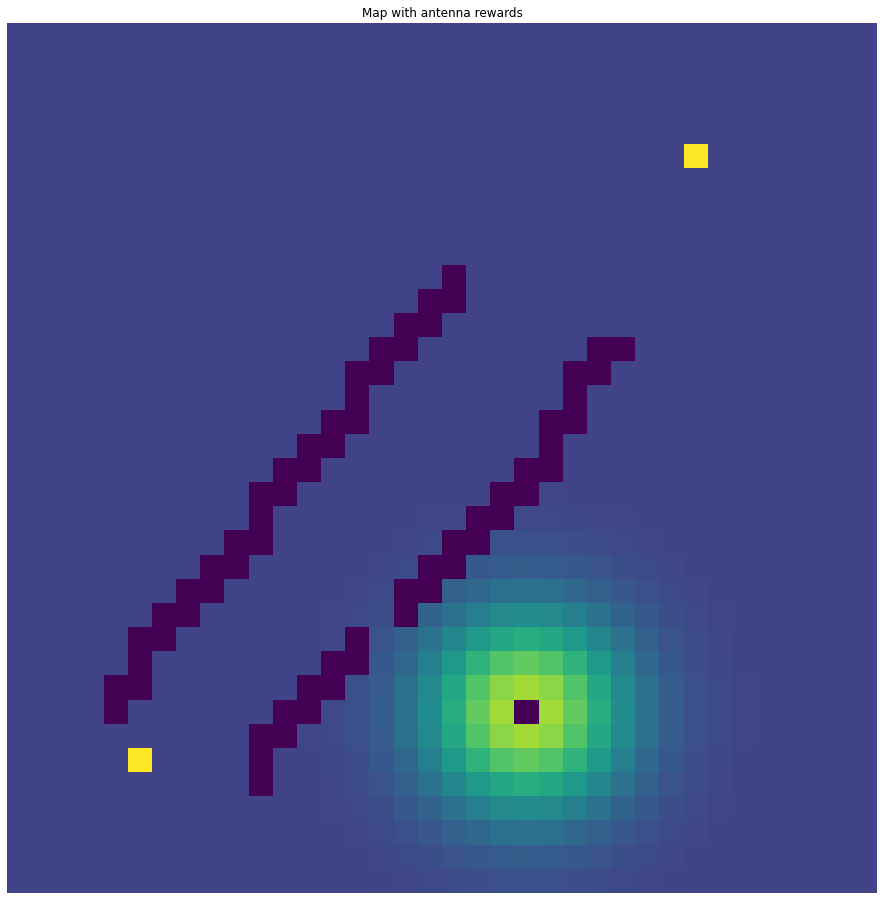

In [13]:
image_path = "urban grids/small.png"
image = Image.open(image_path)
size = image.size
data = np.asarray(image)
fig, ax = plt.subplots(figsize=(16, 16))
ax.axis('off')
ax.set_title('Map')
ax.imshow(data)
cell_types = np.zeros(size, dtype=int)
c = np.zeros(size, dtype=np.float32)
antenna_indexes = []
for x in range(size[0]):
    for y in range(size[1]):
        cell = data[x, y, :]
        if np.array_equal(cell, BLACK):
            cell_types[x, y] = OBSTACLE
            c[x, y] = 0
        elif np.array_equal(cell, WHITE):
            cell_types[x, y] = FREE_CELL
            c[x, y] = base_reward
        elif np.array_equal(cell, GREEN):
            cell_types[x, y] = START
            c[x, y] = 1.0
        elif np.array_equal(cell, BLUE):
            cell_types[x, y] = GOAL
            c[x, y] = 1.0
        elif np.array_equal(cell, YELLOW):
            cell_types[x, y] = OBSTACLE
            antenna_indexes.append((x, y))
obstacle_map = np.where(cell_types == OBSTACLE, 0, 1).astype(np.float32)

start = np.copy(cell_types)
start = np.where(start != START, 0, start)
start = np.where(start == START, 1, start).astype(np.float32)

goal = np.copy(cell_types)
goal = np.where(goal != GOAL, 0, goal)
goal = np.where(goal == GOAL, 1, goal).astype(np.float32)

if len(antenna_indexes) > 0:
    for index in antenna_indexes:
        x = index[0]
        y = index[1]
        x_min_radius = x if x <= radius else radius
        x_max_radius = radius + 1 if x + radius + 1 < size[0] else size[0] - x
        y_min_radius = y if y <= radius else radius
        y_max_radius = radius + 1 if y + radius + 1 < size[1] else size[1] - y
        distribution = antenna_distribution[radius - x_min_radius:radius + x_max_radius,
                       radius - y_min_radius:radius + y_max_radius]
        mask = obstacle_map[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius]
        c[x - x_min_radius:x + x_max_radius, y - y_min_radius:y + y_max_radius] += mask * distribution
    c /= c.max()
    c[c > 0.9] = 0.9
    c[start == 1] = 1
    c[goal == 1] = 1
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.axis('off')
    ax.set_title('Map with antenna rewards')
    ax.imshow(c)

In [15]:
apm = gen_apm()
d = apm.shape[-1] // 2
apm_mask = np.any(apm, 0)
conv_apm = np.transpose(np.expand_dims(apm, -1), (1, 2, 3, 0))
reward = np.tile(c, (9, 1, 1)) * obstacle_map if c is not None else np.tile(obstacle_map[np.newaxis, :],
                                                                 (apm.shape[0], 1, 1))
prob_mask = tf.nn.conv2d(obstacle_map[np.newaxis, :, :, np.newaxis], conv_apm, 1, 'SAME')
prob_mask = tf.squeeze(tf.transpose(prob_mask, (3, 1, 2, 0))).numpy()
for i, j, k in np.argwhere(prob_mask == 0):
    reward[i, j, k] = 0
    prob_mask[i, j, k] = 1

In [9]:
t = 1
T_max = 1000
c = (apm.shape[-1] ** 2) // 2
b_as = np.zeros(apm.shape[:1] + obstacle_map.shape)
prev_b_as = np.zeros(apm.shape[:1] + obstacle_map.shape)
b_as[c, goal == 1] = 1.
while t < T_max:
    b_as = tf.squeeze(tf.nn.convolution(b_as[np.newaxis, :, :, :, np.newaxis], conv_apm, strides=1, padding='SAME'))
    # b_as *= reward / prob_mask

KeyboardInterrupt: 